## Harmonic-percussive source separation ##

/usr/local/lib/python3.5/dist-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


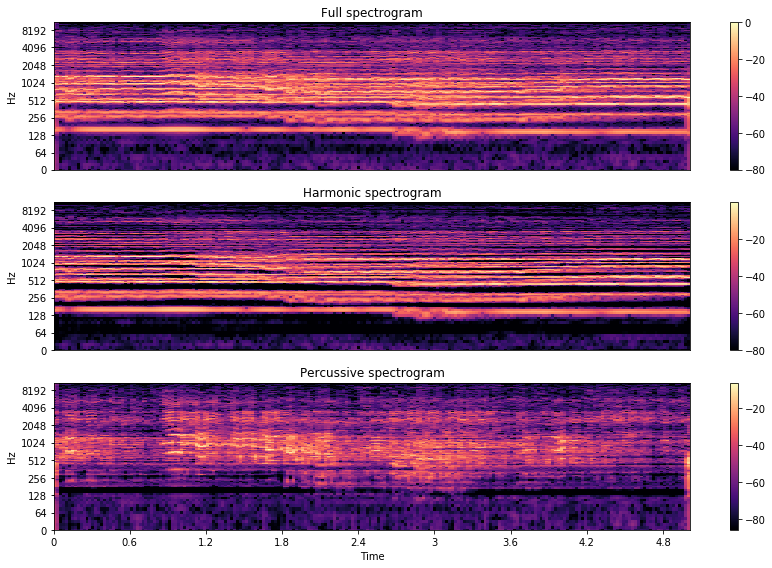

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav', offset=40, duration=5)

# D is the short time Fourier transform

D = librosa.stft(y)

# D should equal D_harmonic+D_percussive

D_harmonic, D_percussive = librosa.decompose.hpss(D)

rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()


It might be reasonable to assume that for vocal seperation, this technique isn't so effective.

### Vocal Separation ##

https://users.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf

/usr/local/lib/python3.5/dist-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.5/dist-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


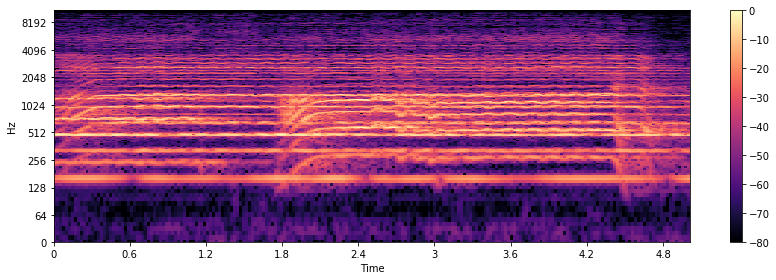

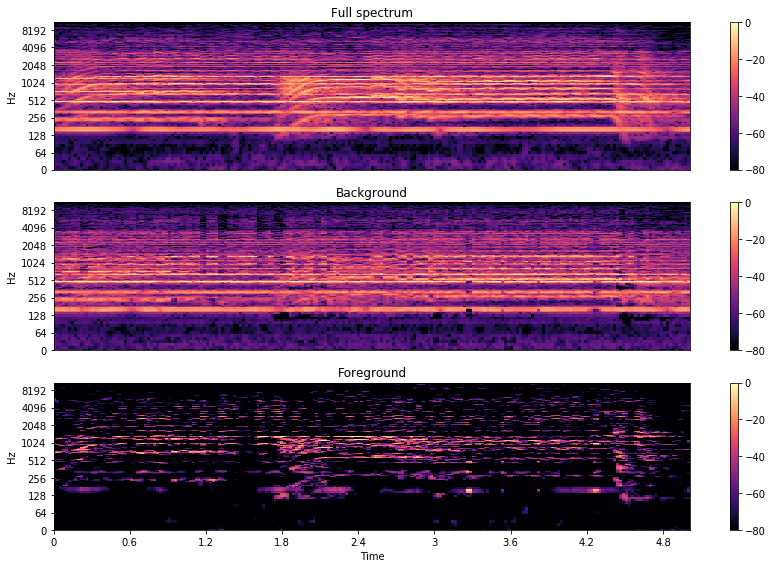

In [9]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display

y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav', duration=120)


#compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

# five second chunk
idx = slice(*librosa.time_to_frames([30, 35], sr=sr))
plt.figure(figsize=(12, 4))

librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()